# Coreg BIC

In [1]:
import geoutils as gu
import matplotlib.pyplot as plt
import numpy as np
import xdem
import rasterio
import geopandas as gpd
from rasterio.mask import mask

from rasterio.features import geometry_mask

import numpy.ma as ma
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

## Input

In [2]:
dem_2021 = xdem.DEM(r"C:\Users\WilsonSIRL5-MCY-E113\Desktop\DEMdifferen\ArcticDEMstripBIC_Clip1_small.tif")
#dem_1960 = xdem.DEM(r"D:\BICdata\catalyst\OneDrive_1_4-9-2024\catalsy1960dem_1_Clip.tif")
dem_1960 = xdem.DEM(r"C:\Users\WilsonSIRL5-MCY-E113\Desktop\DEMdifferen\BICclipDEMs\catalsy1960dem.tif")

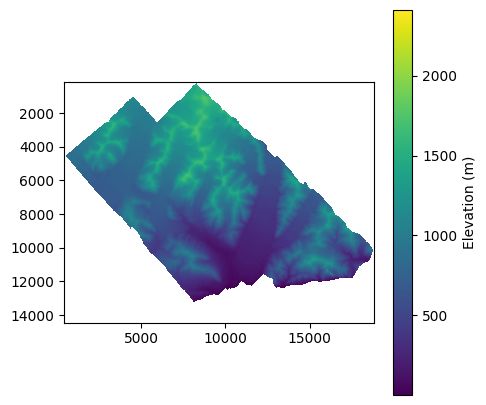

Dem_to_be_aligned Coordinate: EPSG:32617
Nodata value: nan
Resolution: (2.0, 2.0)


In [3]:
dem_to_be_aligned = dem_1960.reproject(res=(2, 2))
dem_to_be_aligned.nodata = np.nan
dem_to_be_aligned.data[dem_to_be_aligned.data == 0] = np.nan
dem_to_be_aligned.data[dem_to_be_aligned.data < 0] = np.nan

# Find the boundaries of the data
rows, cols = np.where(~np.isnan(dem_to_be_aligned.data))
row_min, row_max = np.min(rows), np.max(rows)
col_min, col_max = np.min(cols), np.max(cols)
plt_extent = [col_min, col_max, row_min, row_max]

plt.figure(figsize=(5, 5))

# Visualize the DEM data
im = plt.imshow(dem_to_be_aligned.data.squeeze())

# Adjust the axes to zoom in on the data
plt.xlim(col_min, col_max)
plt.ylim(row_max, row_min)  

plt.colorbar(label='Elevation (m)')
plt.show()

print("Dem_to_be_aligned Coordinate: " + str(dem_to_be_aligned.crs))
print("Nodata value: " + str(dem_to_be_aligned.nodata))
print("Resolution: " + str(dem_to_be_aligned.res))

Reference Coordinate Reference: EPSG:32617
Nodata vale: nan
Resolution: (2.0, 2.0)


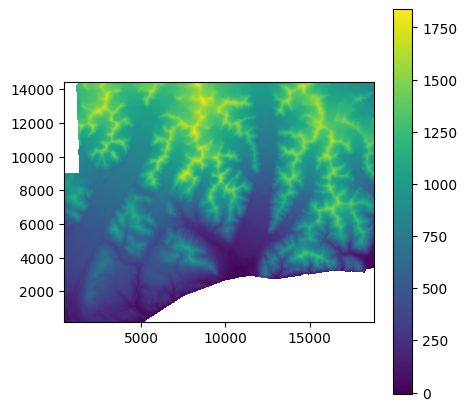

In [4]:
reference_dem = xdem.DEM(dem_2021).reproject(dem_to_be_aligned, resampling='bilinear')
reference_dem.nodata = np.nan

print("Reference Coordinate Reference: " + str(reference_dem.crs))
print("Nodata vale: " + str(reference_dem.nodata))
print("Resolution: " + str(reference_dem.res))

# Visualize the DEM data
plt.figure(figsize=(5, 5))
plt.imshow(reference_dem.data.squeeze(), extent=plt_extent)
plt.colorbar()
plt.show()

In [5]:
glacier_outlines = gu.Vector(r"D:\BICdata\OUTLINE.shp")
print("Outline CRS: " + str(glacier_outlines.crs))

Outline CRS: EPSG:32617


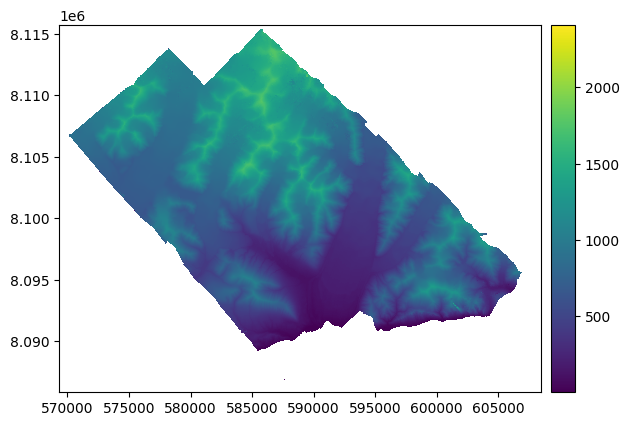

In [6]:
#dem_to_be_aligned.data = xdem.filters.distance_filter(dem_to_be_aligned.data, radius=30, outlier_threshold=10)
#Filter out pixels whose value is distant more than a set threshold from the average value of all neighbor pixels within a given radius.
dem_to_be_aligned.plot()

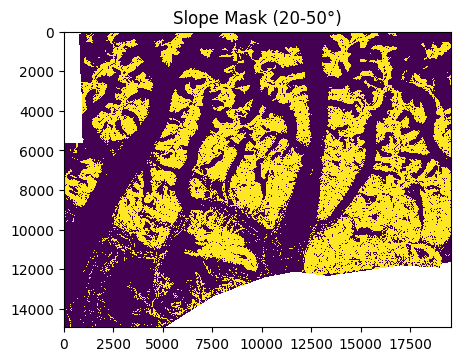

In [7]:
# Calculate slope
slope = xdem.terrain.slope(reference_dem)

# Create masks for slopes between 20-50 degrees
slope_combined_mask  = (slope.data > 20) & (slope.data <= 50) 

# Plot the mask for slopes between 20-50 degrees
plt.figure(figsize=(5, 5))
plt.imshow(slope_combined_mask, interpolation='none')
plt.title("Slope Mask (20-50°)")
plt.show()

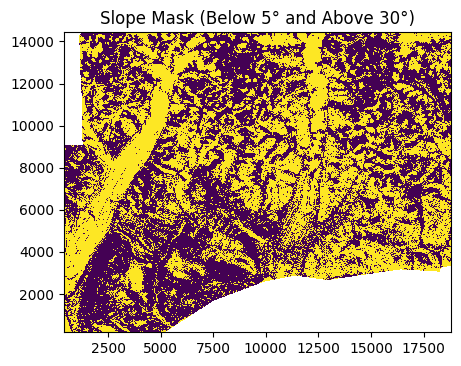

In [8]:
# Calculate slope
slope = xdem.terrain.slope(reference_dem)

# Create masks for slopes below 10 degrees and over 40 degrees
mask_below_5 = slope.data < 5
mask_above_30 = slope.data > 30

# Combine the masks
slope_combined_mask = mask_below_5 | mask_above_30

# Plot the mask for slopes 
plt.figure(figsize=(5, 5))
plt.imshow(slope_combined_mask, interpolation='none', extent=plt_extent)
plt.title("Slope Mask (Below 5° and Above 30°)")
plt.show()

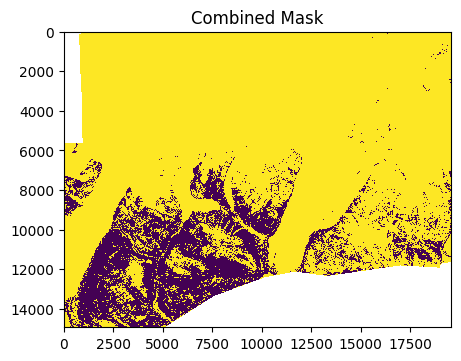

In [9]:
glacier_mask=glacier_outlines.create_mask(reference_dem)

combined_mask = slope_combined_mask + glacier_mask.data

plt.figure(figsize=(5, 5))
plt.imshow(combined_mask, interpolation='none')
plt.title("Combined Mask")
plt.show()

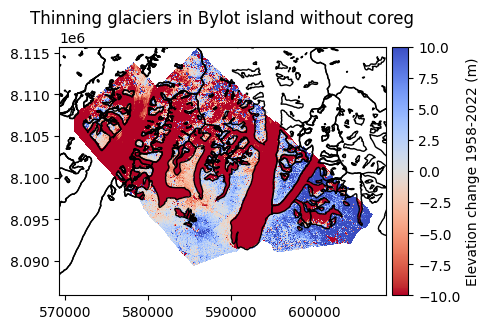

In [10]:
ddem_per = reference_dem - dem_to_be_aligned

plt.figure(figsize=(5, 5))
ax = plt.subplot(111)
glacier_outlines.ds.plot(ax=ax, facecolor='none', edgecolor='k', zorder=2)
ddem_per.plot(ax=ax, cmap='coolwarm_r', vmin=-10, vmax=10, cbar_title='Elevation change 1958-2022 (m)', zorder=1)
ax.set_title('Thinning glaciers in Bylot island without coreg')
plt.tight_layout()
plt.show()

In [11]:
# Copy the elevation difference DEM to avoid modifying the original
mean_dem = ddem_per.copy()

mean_dem.data[combined_mask] = np.nan

# Calculate the mean, median, standard deviation, and NMAD of the non-masked terrain
mean_elevation = np.nanmean(mean_dem.data)
median_elevation = ma.median(ma.masked_invalid(mean_dem.data))
std_dev_elevation = np.nanstd(mean_dem.data)
NMAD = xdem.spatialstats.nmad(mean_dem.data)  

print(f"Mean Elevation: {mean_elevation:.2f}")
print(f"Median Elevation: {median_elevation:.2f}")
print(f"Standard Deviation of Elevation: {std_dev_elevation:.2f}")
print(f"NMAD Elevation: {NMAD:.2f}")

Mean Elevation: 1.60
Median Elevation: 1.49
Standard Deviation of Elevation: 12.55
NMAD Elevation: 4.13


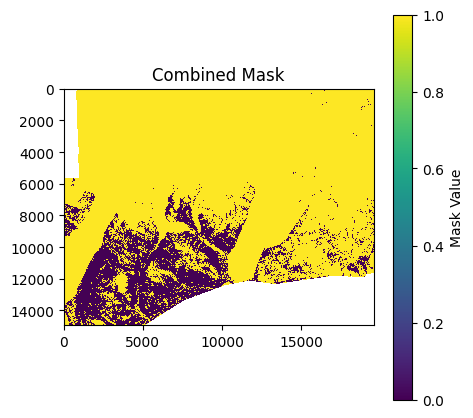

In [12]:
# Create a mask of outliers where the absolute dDEM values exceed NMAD * 3
outlier_mask = np.abs(mean_dem.data) > (NMAD * 3)

combined_mask = combined_mask + outlier_mask.data

plt.figure(figsize=(5, 5))
plt.imshow(combined_mask, interpolation='none')
plt.title("Combined Mask")
plt.colorbar(label='Mask Value')
plt.show()

C:\Users\WilsonSIRL5-MCY-E113\AppData\Local\Temp\ipykernel_2080\3857842482.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


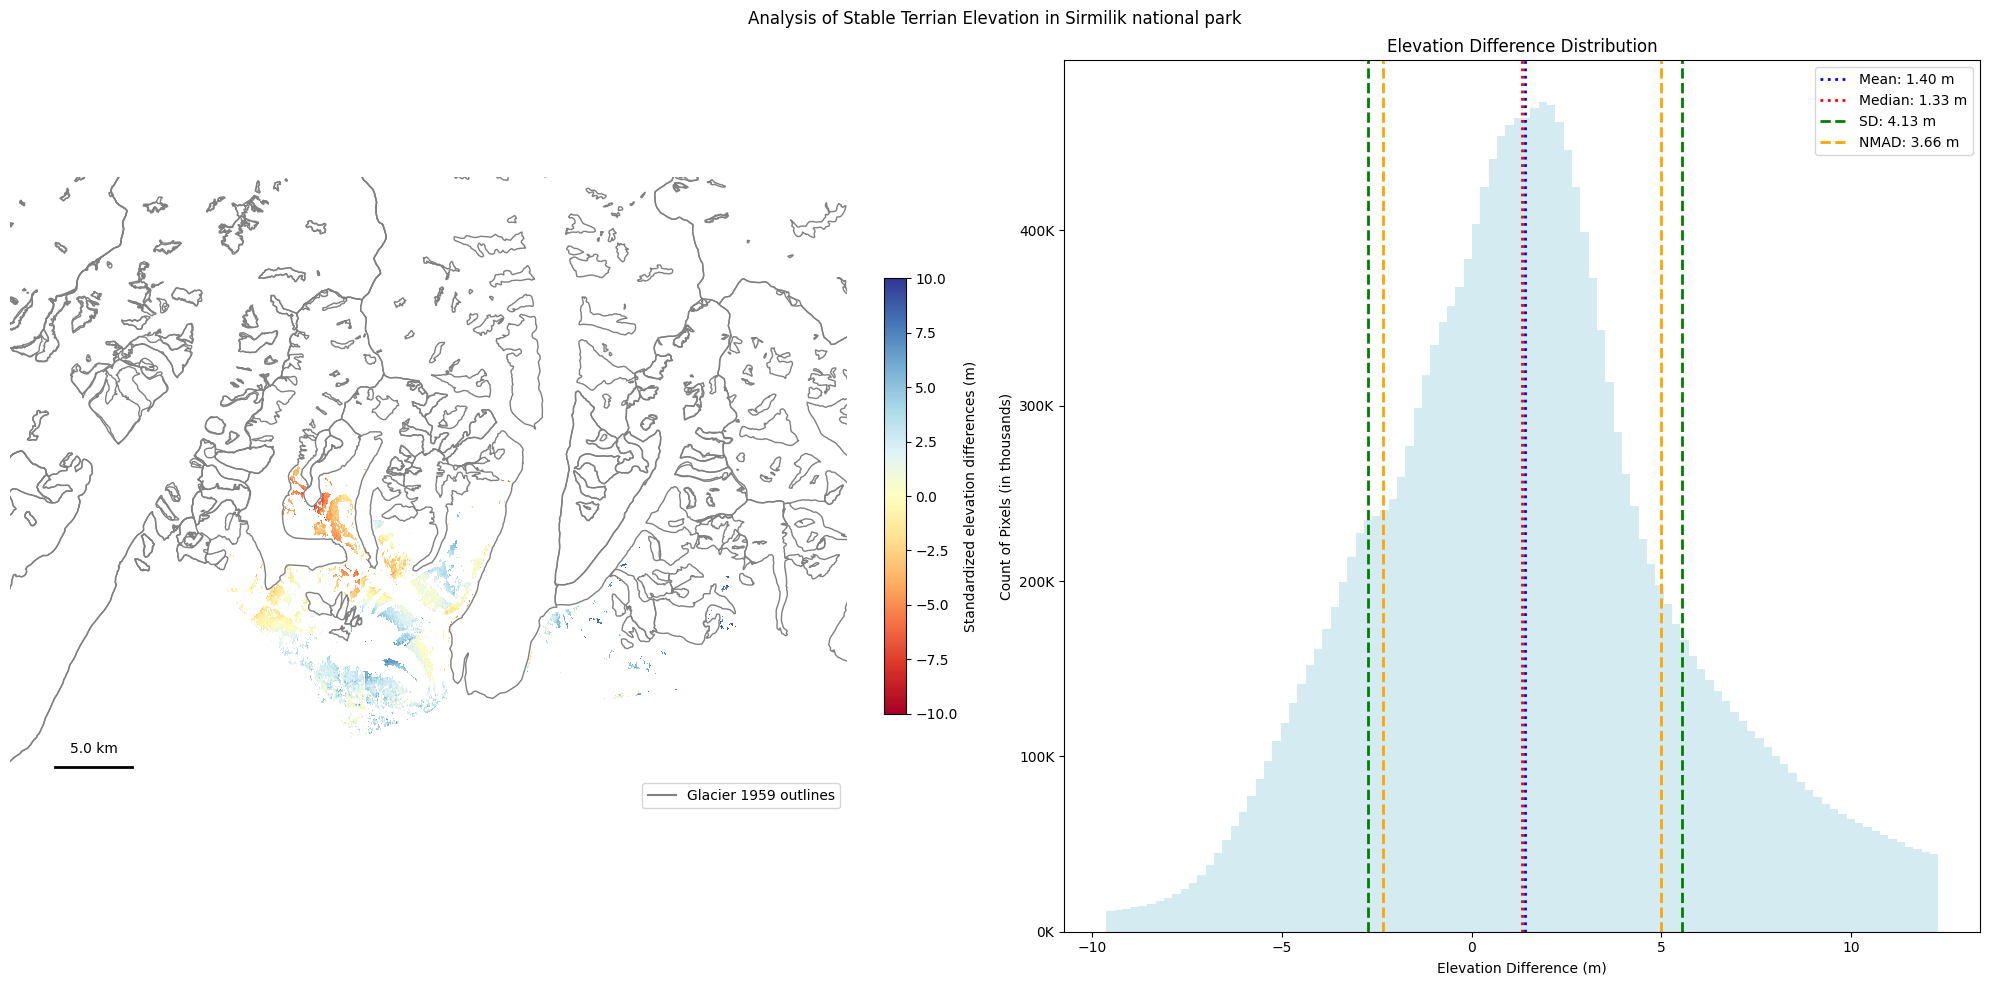

In [13]:
# Copy the elevation difference DEM to avoid modifying the original
mean_dem = ddem_per.copy()

mean_dem.data[combined_mask] = np.nan

mean_dem_float = mean_dem.astype(np.float64)

mean_elevation = np.nanmean(mean_dem.data)
median_elevation = ma.median(ma.masked_invalid(mean_dem.data))
std_dev = np.nanstd(mean_dem.data)
NMAD = xdem.spatialstats.nmad(mean_dem.data)  

elevation_data = mean_dem.data.compressed()
outlier_mask = np.abs(elevation_data - median_elevation) < 3 * NMAD
elevation_data_cleaned = elevation_data[outlier_mask]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# First subplot for the mean DEM with glacier outlines
plt_extent = [
    mean_dem.bounds.left,
    mean_dem.bounds.right,
    mean_dem.bounds.bottom,
    mean_dem.bounds.top,
]

ax1.axis('off')
glacier_outlines.ds.plot(ax=ax1, fc="none", ec="tab:gray", zorder=2)
ax1.plot([], [], color="tab:gray", label="Glacier 1959 outlines")

aspect = mean_dem_float.shape[0] / mean_dem_float.shape[1] * \
         (plt_extent[1] - plt_extent[0]) / (plt_extent[3] - plt_extent[2])

im = ax1.imshow(mean_dem_float.data, cmap="RdYlBu", vmin=-10, vmax=10, extent=plt_extent, aspect=aspect)

cbar = plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04, shrink=0.5)
cbar.set_label("Standardized elevation differences (m)")
ax1.legend(loc="lower right")

# Adding a scale bar as an inset in the first subplot
scalebar_length = 5000  # Define length of the scale bar in meters (5 km)
scalebar_inset = inset_axes(ax1, width="10%", height="2%", loc="lower left", borderpad=3)
scalebar_inset.plot([0, scalebar_length], [0, 0], color='black', linewidth=2, zorder=3)
scalebar_inset.text(scalebar_length / 2, 0.1, f"{scalebar_length / 1000} km", ha='center', va='bottom', zorder=3)
scalebar_inset.axis('off')  

# Second subplot for the histogram
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, loc: "{:,}K".format(int(x/1000))))
ax2.hist(elevation_data_cleaned, bins=100, color='lightblue', alpha=0.5)
ax2.axvline(mean_elevation, color='blue', linestyle='dotted', linewidth=2, label=f'Mean: {mean_elevation:.2f} m')
ax2.axvline(median_elevation, color='red', linestyle='dotted', linewidth=2, label=f'Median: {median_elevation:.2f} m')
ax2.axvline(mean_elevation + std_dev, color='green', linestyle='dashed', linewidth=2, label=f'SD: {std_dev:.2f} m')
ax2.axvline(mean_elevation - std_dev, color='green', linestyle='dashed', linewidth=2)
ax2.axvline(median_elevation + NMAD, color='orange', linestyle='dashed', linewidth=2, label=f'NMAD: {NMAD:.2f} m')
ax2.axvline(median_elevation - NMAD, color='orange', linestyle='dashed', linewidth=2)


ax2.set_xlabel('Elevation Difference (m)')
ax2.set_ylabel('Count of Pixels (in thousands)')
ax2.legend()
ax2.set_title('Elevation Difference Distribution')

# General title for the entire figure
plt.suptitle('Analysis of Stable Terrian Elevation in Sirmilik national park')
plt.tight_layout()
plt.show()

# Co Reg

In [14]:
nuth_kaab = xdem.coreg.NuthKaab()
nuth_kaab.fit(reference_dem, dem_to_be_aligned, inlier_mask=~combined_mask)
corrected_dem = nuth_kaab.apply(dem_to_be_aligned)

# Retrieve the parameters
params = nuth_kaab.meta

params

{'inputs': {'random': {'subsample': 500000.0, 'random_state': None},
  'fitorbin': {'fit_or_bin': 'bin_and_fit',
   'fit_func': <function xdem.coreg.affine._nuth_kaab_fit_func(xx: 'NDArrayf', *params: 'tuple[float, float, float]') -> 'NDArrayf'>,
   'fit_optimizer': <function scipy.optimize._minpack_py.curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=None, bounds=(-inf, inf), method=None, jac=None, *, full_output=False, nan_policy=None, **kwargs)>,
   'bin_sizes': 72,
   'bin_statistic': <function nanmedian at 0x000001DBA1B4C1B0>,
   'nd': 1,
   'bias_var_names': ['aspect']},
  'iterative': {'max_iterations': 10, 'tolerance': 0.001},
  'specific': {},
  'affine': {}},
 'outputs': {'affine': {'shift_x': 0.017943967347224372,
   'shift_y': -0.4875721581479228,
   'shift_z': 1.28125408638698},
  'random': {'subsample_final': 500000}}}

In [15]:
ddem_cont = reference_dem - corrected_dem 

# Copy the elevation difference DEM to avoid modifying the original
mean_dem = ddem_cont.copy()

mean_dem.data[combined_mask] = np.nan

# Calculate the mean, median, standard deviation, and NMAD of the non-masked terrain
mean_elevation = np.nanmean(mean_dem.data)
median_elevation = ma.median(ma.masked_invalid(mean_dem.data))
std_dev_elevation = np.nanstd(mean_dem.data)
NMAD = xdem.spatialstats.nmad(mean_dem.data)  


print(f"Mean Elevation: {mean_elevation:.2f}")
print(f"Median Elevation: {median_elevation:.2f}")
print(f"Standard Deviation of Elevation: {std_dev_elevation:.2f}")
print(f"NMAD Elevation: {NMAD:.2f}")

Mean Elevation: 0.09
Median Elevation: 0.00
Standard Deviation of Elevation: 4.14
NMAD Elevation: 3.63


In [16]:
Deramp = xdem.coreg.Deramp(poly_order=2)
Deramp.fit(reference_dem, corrected_dem, inlier_mask=~combined_mask)
corrected_dem = Deramp.apply(corrected_dem)     

# Retrieve the parameters
params = Deramp.meta

params  

{'inputs': {'random': {'subsample': 500000.0, 'random_state': None},
  'fitorbin': {'fit_func': <function xdem.fit.polynomial_2d(xx: 'tuple[NDArrayf, NDArrayf]', *params: 'NDArrayf') -> 'NDArrayf'>,
   'fit_optimizer': <function scipy.optimize._minpack_py.curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=None, bounds=(-inf, inf), method=None, jac=None, *, full_output=False, nan_policy=None, **kwargs)>,
   'bias_var_names': ['xx', 'yy'],
   'fit_or_bin': 'fit',
   'nd': 2},
  'iterative': {},
  'specific': {'poly_order': 2},
  'affine': {}},
 'outputs': {'random': {'subsample_final': 500000},
  'fitorbin': {'fit_perr': array([5.47350432e-01, 1.15970170e-04, 6.16205099e-09, 1.13649228e-04,
          2.36955297e-08, 1.24100983e-12, 5.84445318e-09, 1.19748915e-12,
          6.16441000e-17]),
   'fit_params': array([-3.72125947e+00, -3.42871102e-03,  3.71595458e-07, -2.66976136e-03,
           8.67082067e-07, -6.46757338e-11,  6.88249966e-08, -1.24128210e-11

In [17]:
ddem_cont = reference_dem - corrected_dem 

# Copy the elevation difference DEM to avoid modifying the original
mean_dem = ddem_cont.copy()

mean_dem.data[combined_mask] = np.nan

# Calculate the mean, median, standard deviation, and NMAD of the non-masked terrain
mean_elevation = np.nanmean(mean_dem.data)
median_elevation = ma.median(ma.masked_invalid(mean_dem.data))
std_dev_elevation = np.nanstd(mean_dem.data)
NMAD = xdem.spatialstats.nmad(mean_dem.data)  

print(f"Mean Elevation: {mean_elevation:.2f}")
print(f"Median Elevation: {median_elevation:.2f}")
print(f"Standard Deviation of Elevation: {std_dev_elevation:.2f}")
print(f"NMAD Elevation: {NMAD:.2f}")

Mean Elevation: -0.00
Median Elevation: -0.01
Standard Deviation of Elevation: 3.04
NMAD Elevation: 2.33


In [18]:
vshift = xdem.coreg.VerticalShift()
vshift.fit(reference_dem, corrected_dem, inlier_mask=~combined_mask)
corrected_dem = vshift.apply(corrected_dem)

# Retrieve the parameters
params = vshift.meta

params

{'inputs': {'random': {'subsample': 1.0},
  'fitorbin': {},
  'iterative': {},
  'specific': {},
  'affine': {'vshift_reduc_func': <function median at 0x000001DBA1B354B0>}},
 'outputs': {'random': {'subsample_final': 18451667},
  'affine': {'shift_z': -0.01458740234375}}}

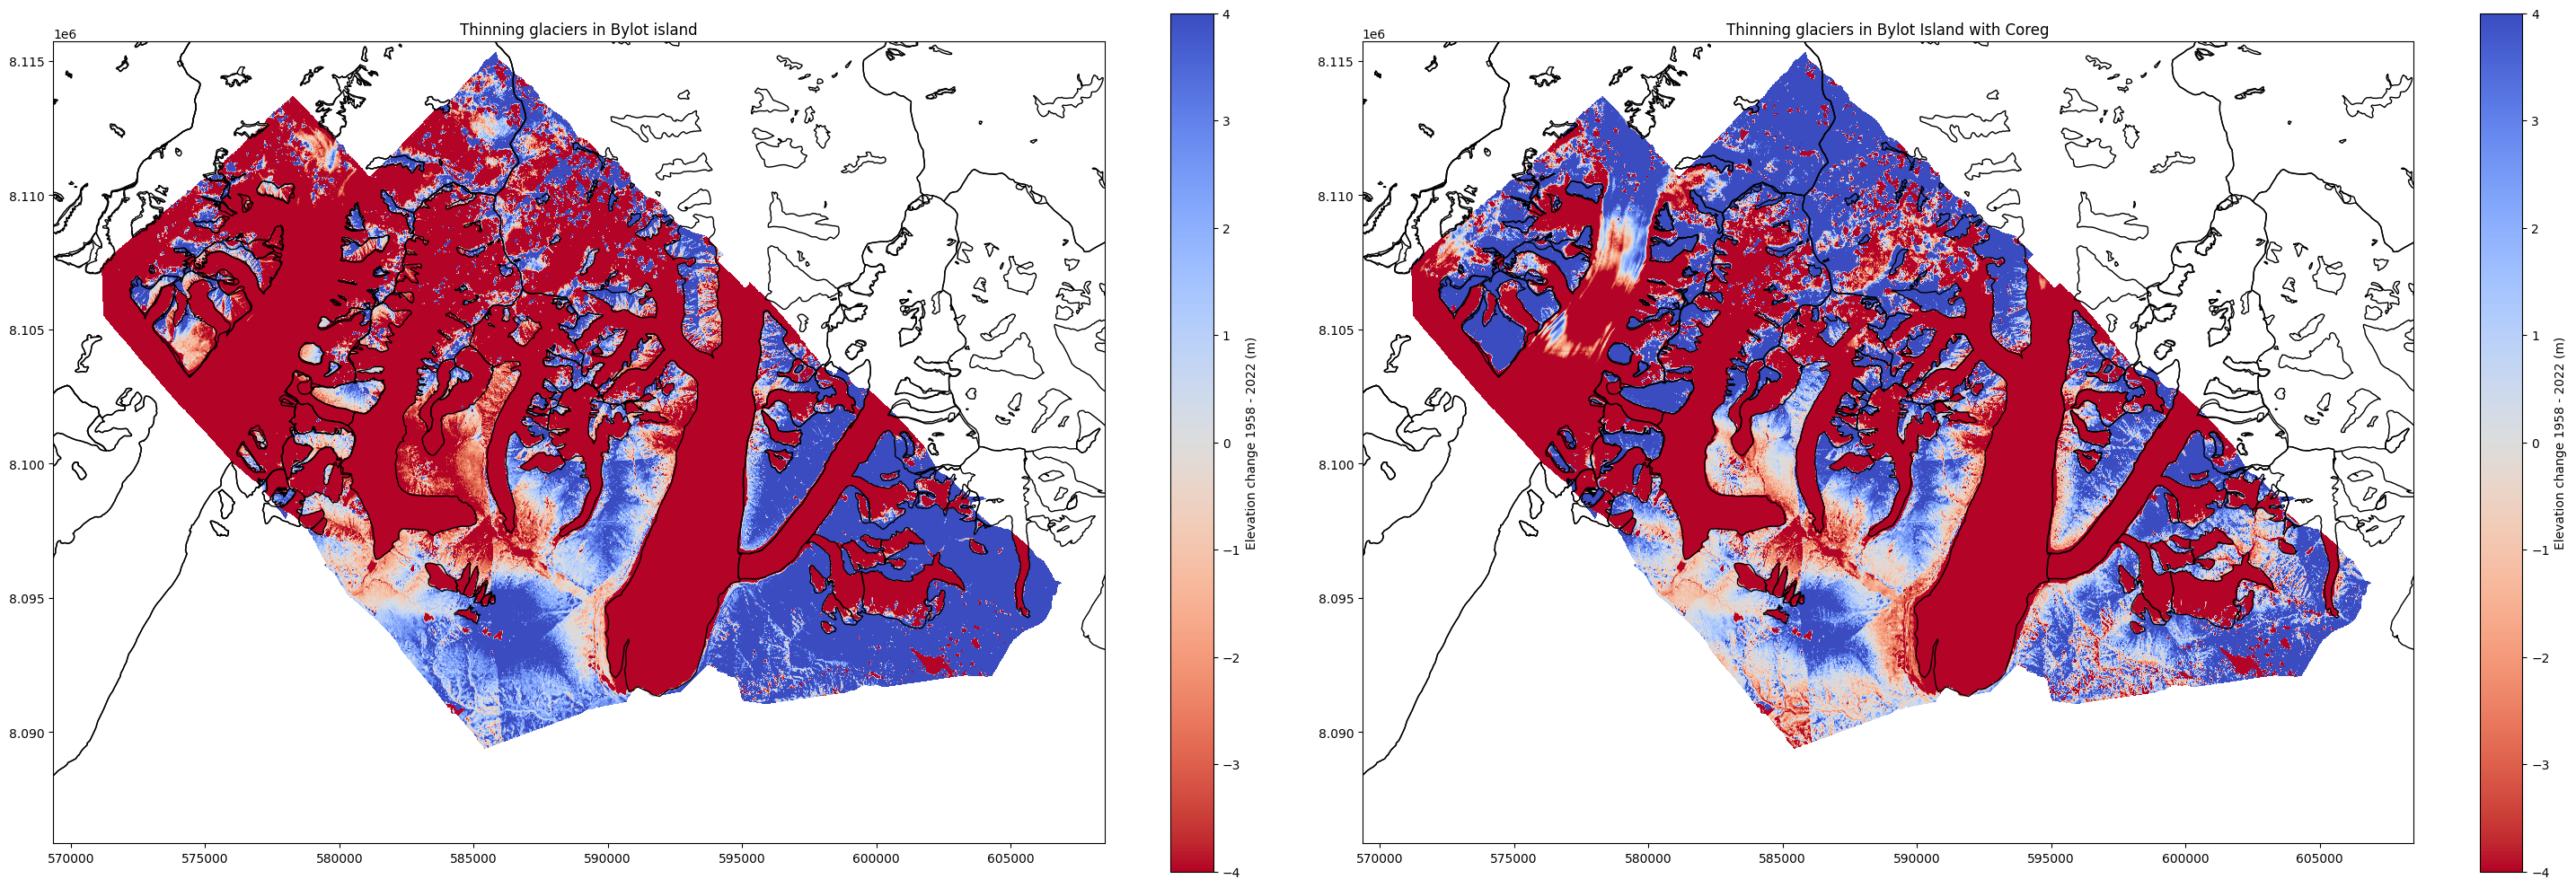

In [19]:
ddem_post = reference_dem - corrected_dem
fig, axs = plt.subplots(1,2, figsize=(30, 10))

# First plot
glacier_outlines.ds.plot(ax=axs[0], facecolor='none', edgecolor='k', zorder=2)
im1 = axs[0].imshow(ddem_per.data, cmap='coolwarm_r', vmin=-4, vmax=4, zorder=1, extent=plt_extent)
cbar1 = fig.colorbar(im1, ax=axs[0], label='Elevation change 1958 - 2022 (m)')
axs[0].set_title('Thinning glaciers in Bylot island')

# Second plot
glacier_outlines.ds.plot(ax=axs[1], facecolor='none', edgecolor='k', zorder=2)
im2 = axs[1].imshow(ddem_post.data, cmap='coolwarm_r', vmin=-4, vmax=4, zorder=1, extent=plt_extent)
cbar2 = fig.colorbar(im2, ax=axs[1], label='Elevation change 1958 - 2022 (m)')
axs[1].set_title('Thinning glaciers in Bylot Island with Coreg')

plt.tight_layout()
plt.show()

C:\Users\WilsonSIRL5-MCY-E113\AppData\Local\Temp\ipykernel_2080\1217858739.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


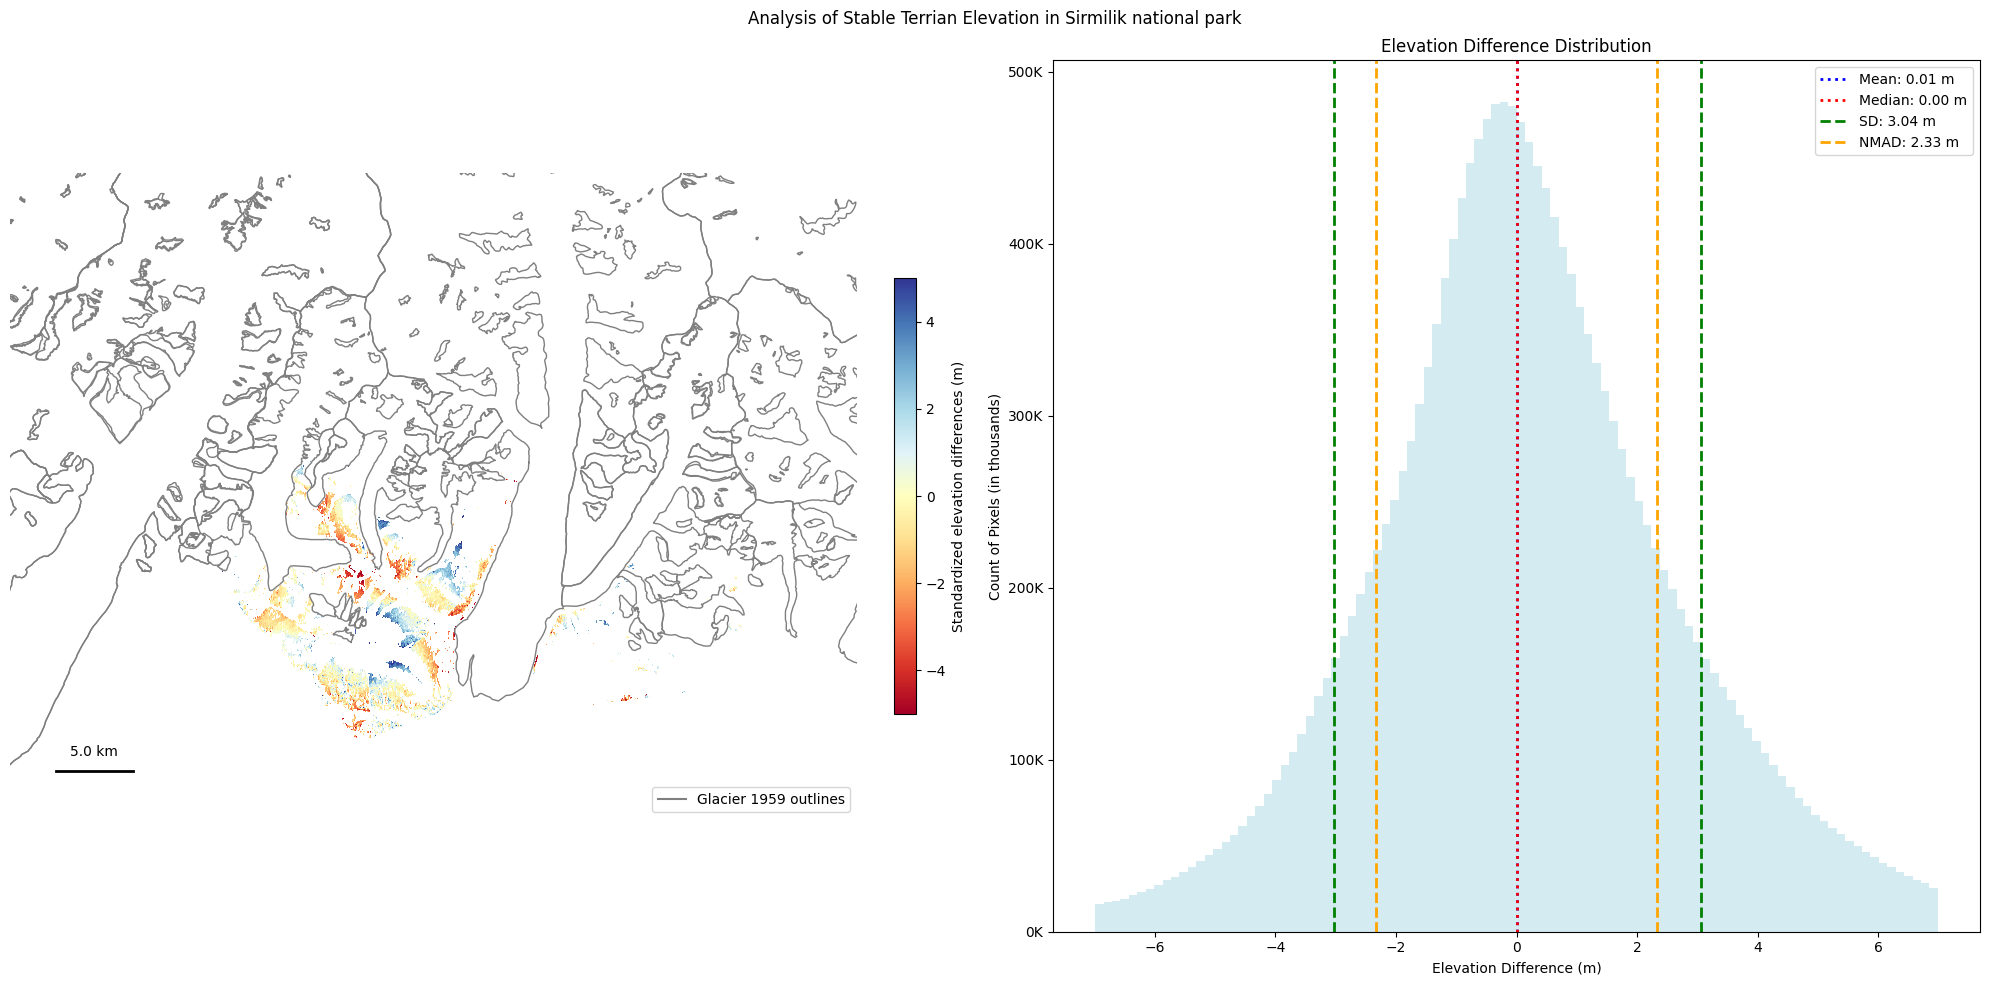

In [20]:
# Copy the elevation difference DEM to avoid modifying the original
mean_dem = ddem_post.copy()

mean_dem.data[combined_mask] = np.nan

mean_dem_float = mean_dem.astype(np.float64)

mean_elevation = np.nanmean(mean_dem.data)
median_elevation = ma.median(ma.masked_invalid(mean_dem.data))
std_dev = np.nanstd(mean_dem.data)
NMAD = xdem.spatialstats.nmad(mean_dem.data)  

elevation_data = mean_dem.data.compressed()
outlier_mask = np.abs(elevation_data - median_elevation) < 3 * NMAD
elevation_data_cleaned = elevation_data[outlier_mask]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# First subplot for the mean DEM with glacier outlines
plt_extent = [
    mean_dem.bounds.left,
    mean_dem.bounds.right,
    mean_dem.bounds.bottom,
    mean_dem.bounds.top,
]

ax1.axis('off')
glacier_outlines.ds.plot(ax=ax1, fc="none", ec="tab:gray", zorder=2)
ax1.plot([], [], color="tab:gray", label="Glacier 1959 outlines")

aspect = mean_dem_float.shape[0] / mean_dem_float.shape[1] * \
         (plt_extent[1] - plt_extent[0]) / (plt_extent[3] - plt_extent[2])

im = ax1.imshow(mean_dem_float.data, cmap="RdYlBu", vmin=-5, vmax=5, extent=plt_extent, aspect=aspect)

cbar = plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04, shrink=0.5)
cbar.set_label("Standardized elevation differences (m)")
ax1.legend(loc="lower right")

# Adding a scale bar as an inset in the first subplot
scalebar_length = 5000  # Define length of the scale bar in meters (5 km)
scalebar_inset = inset_axes(ax1, width="10%", height="2%", loc="lower left", borderpad=3)
scalebar_inset.plot([0, scalebar_length], [0, 0], color='black', linewidth=2, zorder=3)
scalebar_inset.text(scalebar_length / 2, 0.1, f"{scalebar_length / 1000} km", ha='center', va='bottom', zorder=3)
scalebar_inset.axis('off')  

# Second subplot for the histogram
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, loc: "{:,}K".format(int(x/1000))))
ax2.hist(elevation_data_cleaned, bins=100, color='lightblue', alpha=0.5)
ax2.axvline(mean_elevation, color='blue', linestyle='dotted', linewidth=2, label=f'Mean: {mean_elevation:.2f} m')
ax2.axvline(median_elevation, color='red', linestyle='dotted', linewidth=2, label=f'Median: {median_elevation:.2f} m')
ax2.axvline(mean_elevation + std_dev, color='green', linestyle='dashed', linewidth=2, label=f'SD: {std_dev:.2f} m')
ax2.axvline(mean_elevation - std_dev, color='green', linestyle='dashed', linewidth=2)
ax2.axvline(median_elevation + NMAD, color='orange', linestyle='dashed', linewidth=2, label=f'NMAD: {NMAD:.2f} m')
ax2.axvline(median_elevation - NMAD, color='orange', linestyle='dashed', linewidth=2)


ax2.set_xlabel('Elevation Difference (m)')
ax2.set_ylabel('Count of Pixels (in thousands)')
ax2.legend()
ax2.set_title('Elevation Difference Distribution')

# General title for the entire figure
plt.suptitle('Analysis of Stable Terrian Elevation in Sirmilik national park')
plt.tight_layout()
plt.show()

In [21]:
ddem_post.save("D:\BICdata\BICDEMLcoreg_ddempost.tif")

## Calculate uncertainties in geodetic mass balance

#### Load the relevant data

In [22]:
dh = xdem.DEM(ddem_post)
ref_dem = xdem.DEM(reference_dem)
glacier_outlines = gu.Vector(glacier_outlines)

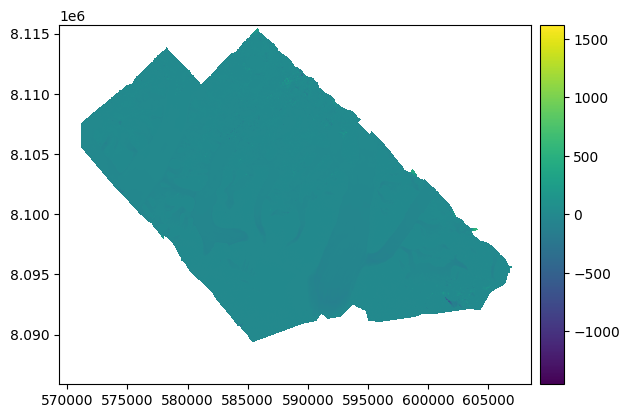

In [23]:
dh.plot()

## Empirical variogram and plot

In [24]:
list_models=["Spherical", "Spherical"]

(
    df_empirical_variogram,
    df_model_params,
    spatial_corr_function,
) = xdem.spatialstats.infer_spatial_correlation_from_stable(
    dvalues=dh, list_models=list_models, unstable_mask=glacier_outlines
)

c:\Users\WilsonSIRL5-MCY-E113\miniconda3\envs\xdem\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


### Some results from the variogram fit

In [25]:
df_model_params

model         range      psill
0  spherical     10.745954  18.688126
0  spherical  46340.950012  15.031243

In [26]:
for spatial_lag in [0, 100, 1000, 10000, 30000]:
    print(
        "Errors are correlated at {:.1f}% for a {:,.0f} m spatial lag".format(
            spatial_corr_function(spatial_lag) * 100, spatial_lag
        )
    )

Errors are correlated at 100.0% for a 0 m spatial lag
Errors are correlated at 44.4% for a 100 m spatial lag
Errors are correlated at 43.1% for a 1,000 m spatial lag
Errors are correlated at 30.4% for a 10,000 m spatial lag
Errors are correlated at 7.3% for a 30,000 m spatial lag


#### Plot the variogram

<Figure size 640x480 with 0 Axes>

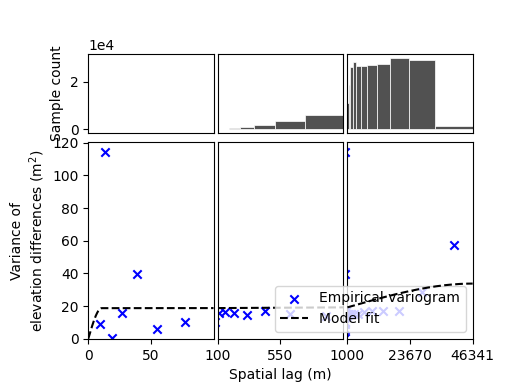

In [27]:
plt.figure()
xdem.spatialstats.plot_variogram(
    df=df_empirical_variogram,
    list_fit_fun=[xdem.spatialstats.get_variogram_model_func(df_model_params)],
    xlabel="Spatial lag (m)",
    ylabel="Variance of\nelevation differences (m$^2$)",
    xscale_range_split=[100,1000],
)

### Estimate heteroscedasticity 

#####  First calculate terrain derivatives (slope, curvature)

In [28]:
slope, maximum_curvature = xdem.terrain.get_terrain_attribute(ref_dem, attribute=["slope", "maximum_curvature"])
errors, df_binning, error_function = xdem.spatialstats.infer_heteroscedasticity_from_stable(
    dvalues=dh, list_var=[slope, maximum_curvature], list_var_names=["slope", "maxc"], unstable_mask=glacier_outlines
)

#####  Normalize variance and calculate new variogram

In [29]:
zscores = dh / errors
emp_variogram, params_variogram_model, spatial_corr_function = xdem.spatialstats.infer_spatial_correlation_from_stable(
    dvalues=zscores, list_models=list_models, unstable_mask=glacier_outlines
)

c:\Users\WilsonSIRL5-MCY-E113\miniconda3\envs\xdem\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


##### Some results from the variogram fit

In [30]:
params_variogram_model

model         range     psill
0  spherical      0.425777  1.202550
0  spherical  46340.950012  1.957978

####  Plot normalized variogram

<Figure size 640x480 with 0 Axes>

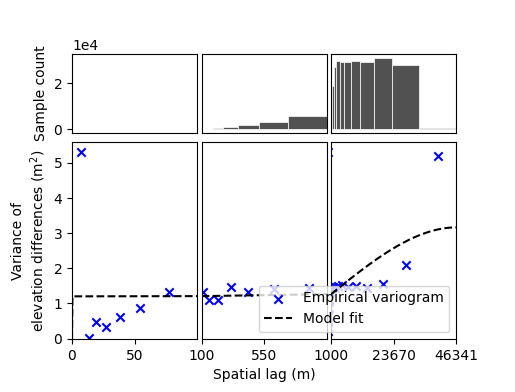

In [31]:
plt.figure()
xdem.spatialstats.plot_variogram(
    df=emp_variogram,
    list_fit_fun=[xdem.spatialstats.get_variogram_model_func(params_variogram_model)],
    xlabel="Spatial lag (m)",
    ylabel="Variance of\nelevation differences (m$^2$)",
    xscale_range_split=[100,1000],
)

#####  Spatial integration of variance on the target area

In [32]:
areas = [
    226555916., ## Sermilik 
    35778128., ## Fountain 
]

stderr_glaciers = xdem.spatialstats.spatial_error_propagation(
    areas=areas, errors=errors, params_variogram_model=params_variogram_model
)

for glacier_name, stderr_gla in [("Sermilik", stderr_glaciers[0]), ("Fountain ", stderr_glaciers[1])]:
    print(f"The error (1-sigma) in mean elevation change for {glacier_name} is {stderr_gla:.2f} meters.")

The error (1-sigma) in mean elevation change for Sermilik is 2.43 meters.
The error (1-sigma) in mean elevation change for Fountain  is 2.58 meters.


C:\Users\WilsonSIRL5-MCY-E113\AppData\Local\Temp\ipykernel_2080\3657351762.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


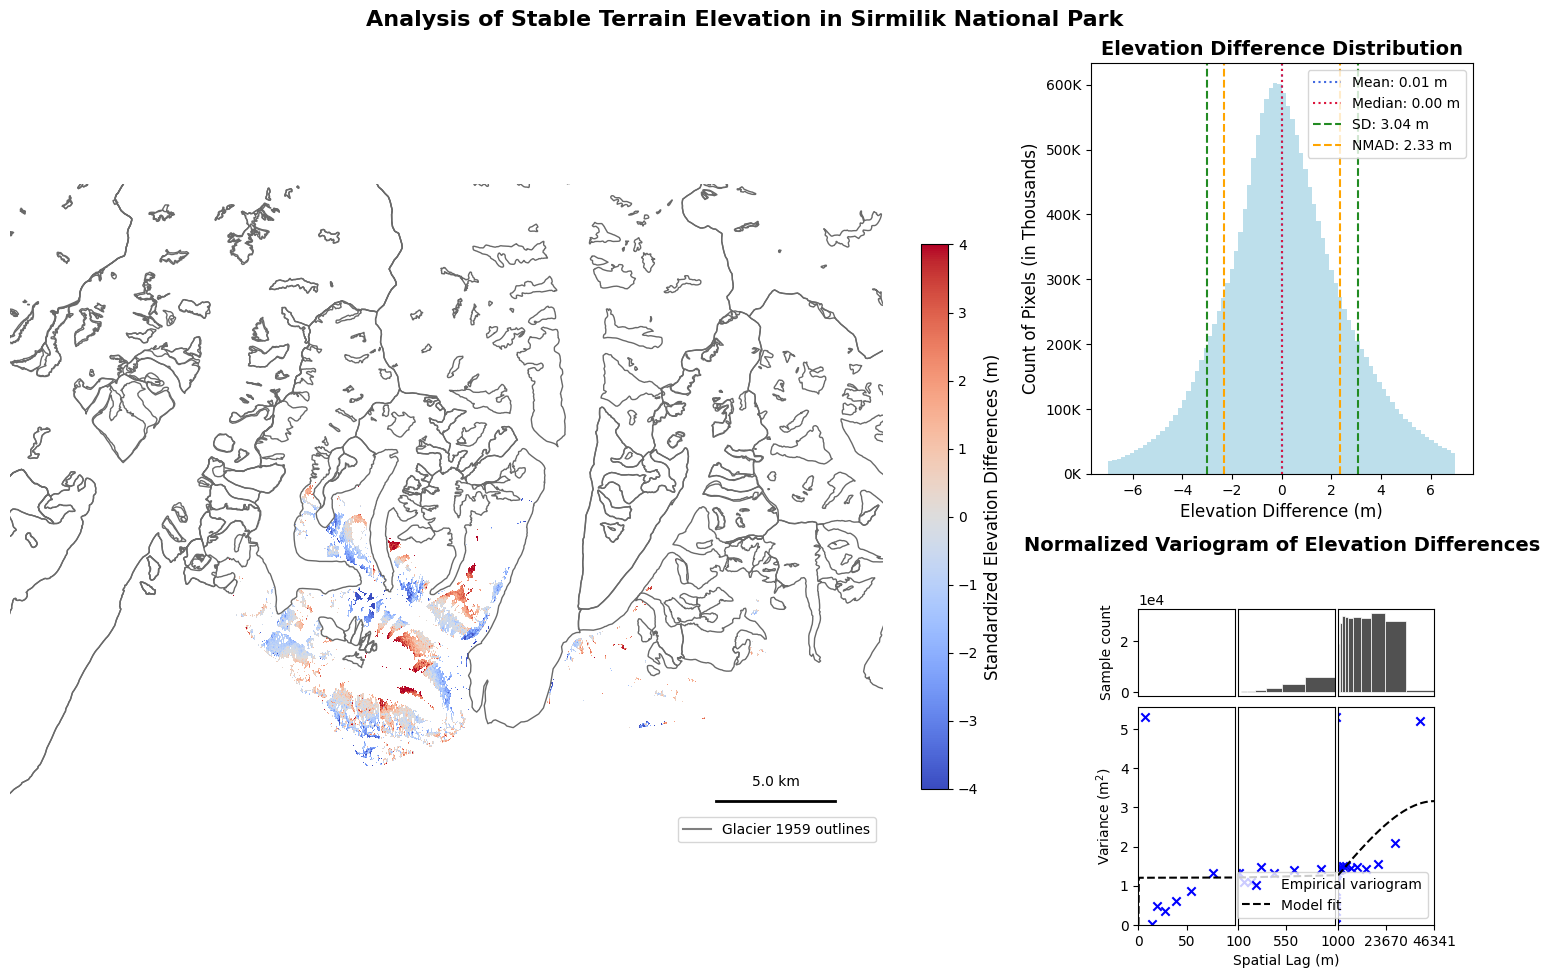

In [33]:
# Create a figure with two subplots
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], width_ratios=[2.5, 1])  

# First subplot for the mean DEM with glacier outlines
ax1 = fig.add_subplot(gs[:, 0])  # Span both rows on the left column
plt_extent = [
    mean_dem.bounds.left,
    mean_dem.bounds.right,
    mean_dem.bounds.bottom,
    mean_dem.bounds.top,
]
ax1.axis('off')
glacier_outlines.ds.plot(ax=ax1, fc="none", ec="dimgray", zorder=2)
ax1.plot([], [], color="tab:gray", label="Glacier 1959 outlines")

aspect = mean_dem_float.shape[0] / mean_dem_float.shape[1] * \
         (plt_extent[1] - plt_extent[0]) / (plt_extent[3] - plt_extent[2])
im = ax1.imshow(mean_dem_float.data, cmap="coolwarm", vmin=-4, vmax=4, extent=plt_extent, aspect=aspect)

# Color bar customization
cbar = plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04, shrink=0.6)
cbar.set_label("Standardized Elevation Differences (m)", fontsize=12)

# Adding a scale bar as an inset in the first subplot
scalebar_length = 5000  # Define length of the scale bar in meters (5 km)
scalebar_inset = inset_axes(ax1, width="15%", height="2%", loc="lower right", borderpad=3)
scalebar_inset.plot([0, scalebar_length], [0, 0], color='black', linewidth=2, zorder=3)
scalebar_inset.text(scalebar_length / 2, 0.1, f"{scalebar_length / 1000} km", ha='center', va='bottom', zorder=3, fontsize=10)
scalebar_inset.axis('off')
ax1.legend(loc="lower right", fontsize=10)

# Second subplot for the histogram with reduced height and improved styles
ax2 = fig.add_subplot(gs[0, 1])
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, loc: "{:,}K".format(int(x/1000))))
ax2.hist(elevation_data_cleaned, bins=80, color='lightblue', alpha=0.8)
ax2.axvline(mean_elevation, color='royalblue', linestyle='dotted', linewidth=1.5, label=f'Mean: {mean_elevation:.2f} m')
ax2.axvline(median_elevation, color='crimson', linestyle='dotted', linewidth=1.5, label=f'Median: {median_elevation:.2f} m')
ax2.axvline(mean_elevation + std_dev, color='forestgreen', linestyle='dashed', linewidth=1.5, label=f'SD: {std_dev:.2f} m')
ax2.axvline(mean_elevation - std_dev, color='forestgreen', linestyle='dashed', linewidth=1.5)
ax2.axvline(median_elevation + NMAD, color='orange', linestyle='dashed', linewidth=1.5, label=f'NMAD: {NMAD:.2f} m')
ax2.axvline(median_elevation - NMAD, color='orange', linestyle='dashed', linewidth=1.5)
ax2.set_xlabel('Elevation Difference (m)', fontsize=12)
ax2.set_ylabel('Count of Pixels (in Thousands)', fontsize=12)
ax2.legend(loc="upper right", fontsize=10)
ax2.set_title('Elevation Difference Distribution', fontsize=14, weight='bold')

# Third subplot for the variogram below the histogram with adjustments
ax3 = fig.add_subplot(gs[1, 1])
xdem.spatialstats.plot_variogram(
    df=emp_variogram,
    list_fit_fun=[xdem.spatialstats.get_variogram_model_func(params_variogram_model)],
    xlabel="Spatial Lag (m)",
    ylabel="Variance (m$^2$)",
    xscale_range_split=[100, 1000],
    ax=ax3
)
ax3.set_title('Normalized Variogram of Elevation Differences', fontsize=14, weight='bold')
ax3.grid(True, linestyle='--', alpha=0.7)

# General title for the entire figure
plt.suptitle('Analysis of Stable Terrain Elevation in Sirmilik National Park', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

In [34]:
hwehwheh

NameError: name 'hwehwheh' is not defined

C:\Users\WilsonSIRL5-MCY-E113\AppData\Local\Temp\ipykernel_22852\2372165899.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


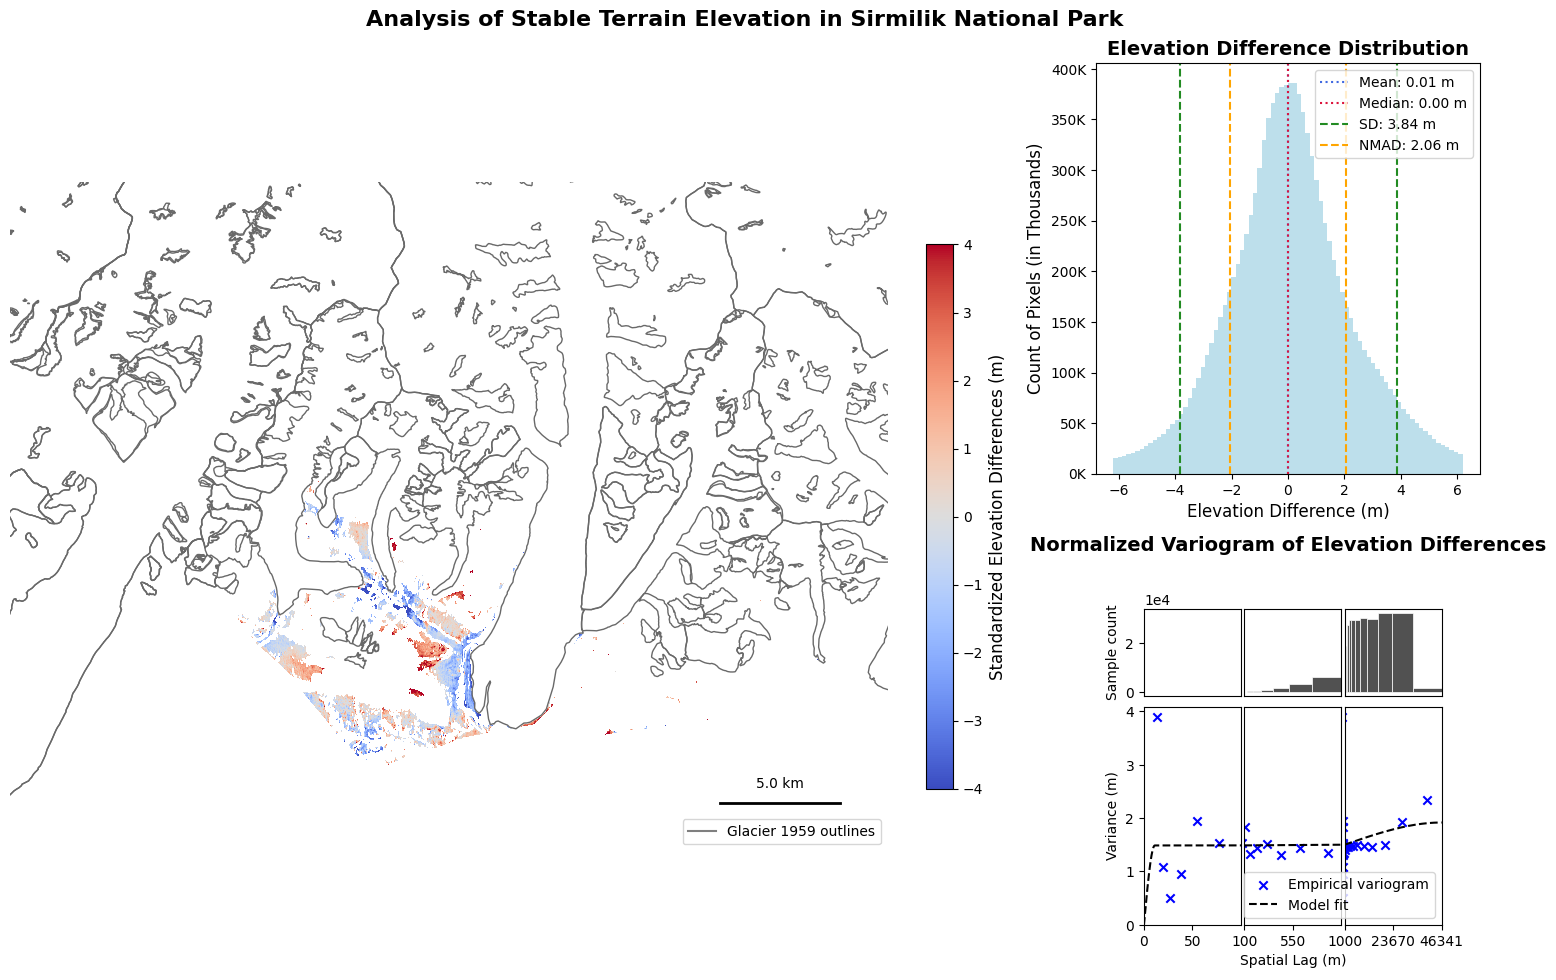

In [ ]:
# Create a figure with an adjusted layout for a professional look
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], width_ratios=[2.5, 1])  

# First subplot for the mean DEM with glacier outlines
ax1 = fig.add_subplot(gs[:, 0])  # Span both rows on the left column
plt_extent = [
    mean_dem.bounds.left,
    mean_dem.bounds.right,
    mean_dem.bounds.bottom,
    mean_dem.bounds.top,
]
ax1.axis('off')
glacier_outlines.ds.plot(ax=ax1, fc="none", ec="dimgray", zorder=2)
ax1.plot([], [], color="tab:gray", label="Glacier 1959 outlines")

aspect = mean_dem_float.shape[0] / mean_dem_float.shape[1] * \
         (plt_extent[1] - plt_extent[0]) / (plt_extent[3] - plt_extent[2])
im = ax1.imshow(mean_dem_float.data, cmap="coolwarm", vmin=-4, vmax=4, extent=plt_extent, aspect=aspect)

# Color bar customization
cbar = plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04, shrink=0.6)
cbar.set_label("Standardized Elevation Differences (m)", fontsize=12)

# Adding a scale bar as an inset in the first subplot
scalebar_length = 5000  # Define length of the scale bar in meters (5 km)
scalebar_inset = inset_axes(ax1, width="15%", height="2%", loc="lower right", borderpad=3)
scalebar_inset.plot([0, scalebar_length], [0, 0], color='black', linewidth=2, zorder=3)
scalebar_inset.text(scalebar_length / 2, 0.1, f"{scalebar_length / 1000} km", ha='center', va='bottom', zorder=3, fontsize=10)
scalebar_inset.axis('off')
ax1.legend(loc="lower right", fontsize=10)

# Second subplot for the histogram with reduced height and improved styles
ax2 = fig.add_subplot(gs[0, 1])
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, loc: "{:,}K".format(int(x/1000))))
ax2.hist(elevation_data_cleaned, bins=80, color='lightblue', alpha=0.8)
ax2.axvline(mean_elevation, color='royalblue', linestyle='dotted', linewidth=1.5, label=f'Mean: {mean_elevation:.2f} m')
ax2.axvline(median_elevation, color='crimson', linestyle='dotted', linewidth=1.5, label=f'Median: {median_elevation:.2f} m')
ax2.axvline(mean_elevation + std_dev, color='forestgreen', linestyle='dashed', linewidth=1.5, label=f'SD: {std_dev:.2f} m')
ax2.axvline(mean_elevation - std_dev, color='forestgreen', linestyle='dashed', linewidth=1.5)
ax2.axvline(median_elevation + NMAD, color='orange', linestyle='dashed', linewidth=1.5, label=f'NMAD: {NMAD:.2f} m')
ax2.axvline(median_elevation - NMAD, color='orange', linestyle='dashed', linewidth=1.5)
ax2.set_xlabel('Elevation Difference (m)', fontsize=12)
ax2.set_ylabel('Count of Pixels (in Thousands)', fontsize=12)
ax2.legend(loc="upper right", fontsize=10)
ax2.set_title('Elevation Difference Distribution', fontsize=14, weight='bold')

# Third subplot for the variogram below the histogram with adjustments
ax3 = fig.add_subplot(gs[1, 1])
xdem.spatialstats.plot_variogram(
    df=emp_variogram,
    list_fit_fun=[xdem.spatialstats.get_variogram_model_func(params_variogram_model)],
    xlabel="Spatial Lag (m)",
    ylabel="Variance (m)",
    xscale_range_split=[100, 1000],
    ax=ax3
)
ax3.set_title('Normalized Variogram of Elevation Differences', fontsize=14, weight='bold')
ax3.grid(True, linestyle='--', alpha=0.7)

# General title for the entire figure
plt.suptitle('Analysis of Stable Terrain Elevation in Sirmilik National Park', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

C:\Users\WilsonSIRL5-MCY-E113\AppData\Local\Temp\ipykernel_22852\1066234647.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


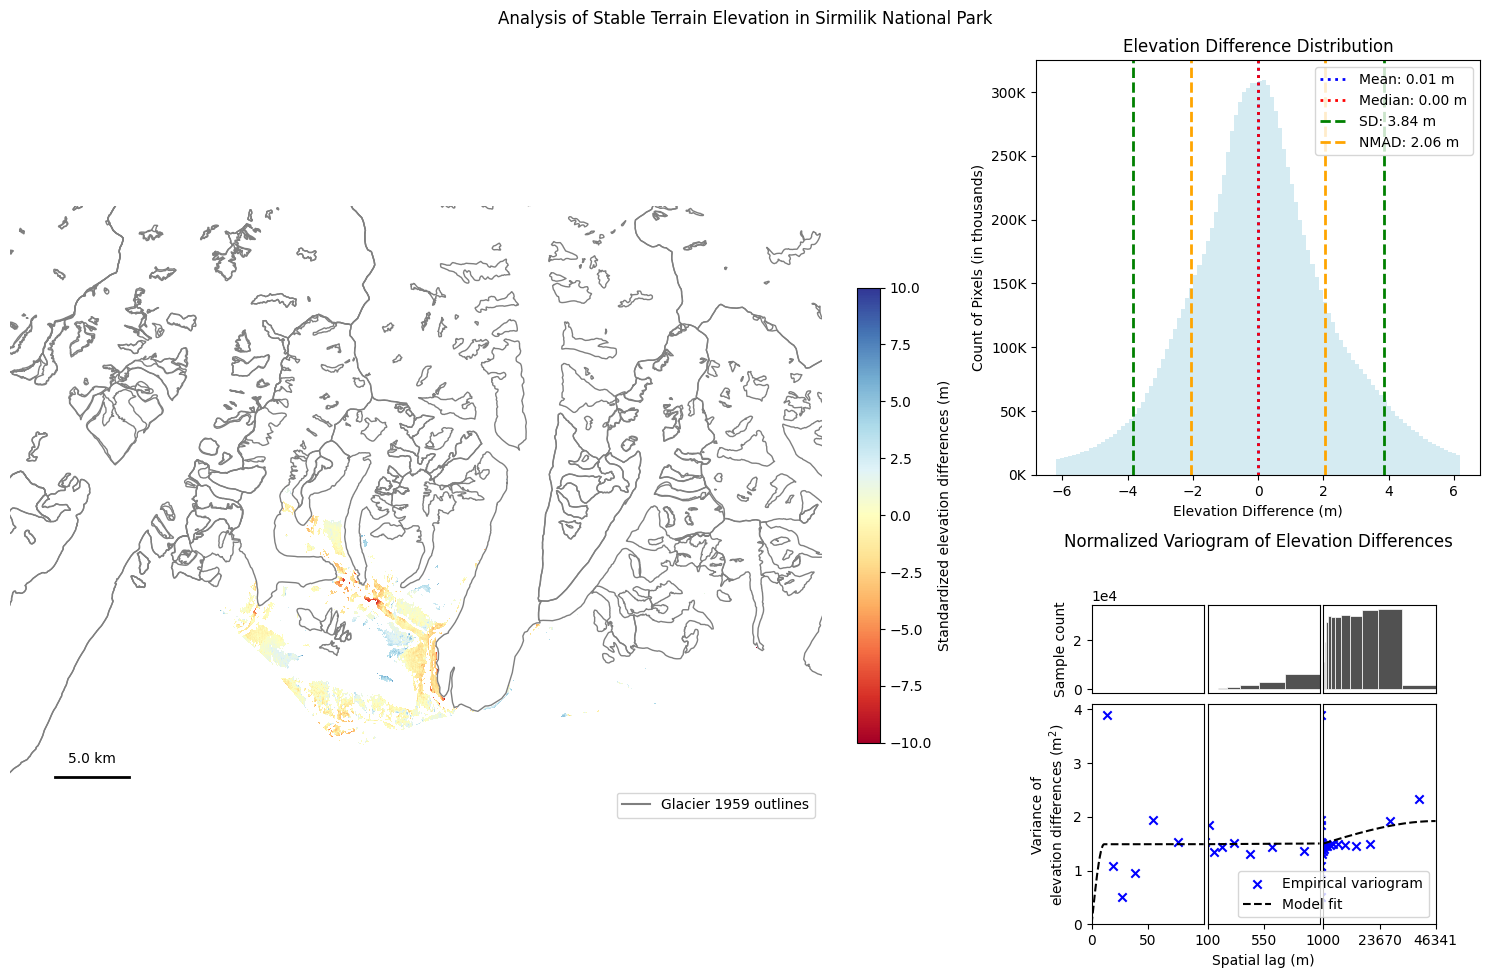

In [ ]:
# Create a figure with three subplots, placing the histogram and variogram vertically on the right
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], width_ratios=[2, 1])  # Adjust for layout with two rows on the right

# First subplot for the mean DEM with glacier outlines
ax1 = fig.add_subplot(gs[:, 0])  # Span both rows on the left column
plt_extent = [
    mean_dem.bounds.left,
    mean_dem.bounds.right,
    mean_dem.bounds.bottom,
    mean_dem.bounds.top,
]
ax1.axis('off')
glacier_outlines.ds.plot(ax=ax1, fc="none", ec="tab:gray", zorder=2)
ax1.plot([], [], color="tab:gray", label="Glacier 1959 outlines")

aspect = mean_dem_float.shape[0] / mean_dem_float.shape[1] * \
         (plt_extent[1] - plt_extent[0]) / (plt_extent[3] - plt_extent[2])
im = ax1.imshow(mean_dem_float.data, cmap="RdYlBu", vmin=-10, vmax=10, extent=plt_extent, aspect=aspect)

cbar = plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04, shrink=0.5)
cbar.set_label("Standardized elevation differences (m)")
ax1.legend(loc="lower right")

# Adding a scale bar as an inset in the first subplot
scalebar_length = 5000  # Define length of the scale bar in meters (5 km)
scalebar_inset = inset_axes(ax1, width="10%", height="2%", loc="lower left", borderpad=3)
scalebar_inset.plot([0, scalebar_length], [0, 0], color='black', linewidth=2, zorder=3)
scalebar_inset.text(scalebar_length / 2, 0.1, f"{scalebar_length / 1000} km", ha='center', va='bottom', zorder=3)
scalebar_inset.axis('off')

# Second subplot for the histogram in the top right corner
ax2 = fig.add_subplot(gs[0, 1])
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, loc: "{:,}K".format(int(x/1000))))
ax2.hist(elevation_data_cleaned, bins=100, color='lightblue', alpha=0.5)
ax2.axvline(mean_elevation, color='blue', linestyle='dotted', linewidth=2, label=f'Mean: {mean_elevation:.2f} m')
ax2.axvline(median_elevation, color='red', linestyle='dotted', linewidth=2, label=f'Median: {median_elevation:.2f} m')
ax2.axvline(mean_elevation + std_dev, color='green', linestyle='dashed', linewidth=2, label=f'SD: {std_dev:.2f} m')
ax2.axvline(mean_elevation - std_dev, color='green', linestyle='dashed', linewidth=2)
ax2.axvline(median_elevation + NMAD, color='orange', linestyle='dashed', linewidth=2, label=f'NMAD: {NMAD:.2f} m')
ax2.axvline(median_elevation - NMAD, color='orange', linestyle='dashed', linewidth=2)
ax2.set_xlabel('Elevation Difference (m)')
ax2.set_ylabel('Count of Pixels (in thousands)')
ax2.legend()
ax2.set_title('Elevation Difference Distribution')

# Third subplot for the variogram below the histogram
ax3 = fig.add_subplot(gs[1, 1])
xdem.spatialstats.plot_variogram(
    df=emp_variogram,
    list_fit_fun=[xdem.spatialstats.get_variogram_model_func(params_variogram_model)],
    xlabel="Spatial lag (m)",
    ylabel="Variance of\nelevation differences (m$^2$)",
    xscale_range_split=[100, 1000],
    ax=ax3
)
ax3.set_title('Normalized Variogram of Elevation Differences')

# General title for the entire figure
plt.suptitle('Analysis of Stable Terrain Elevation in Sirmilik National Park')
plt.tight_layout()
plt.show()

# !!Merge together

In [ ]:
# Load the two DEMs as Raster objects
dem1 = Raster("D:\BICdata\BICDEMLcoreg.tif")
dem2 = Raster("D:\BICdata\BICDEMRcoreg.tif")

# Merge the two DEMs
merged_dem = gu.raster.merge_rasters([dem1, dem2], reference=reference_dem)

NameError: name 'Raster' is not defined

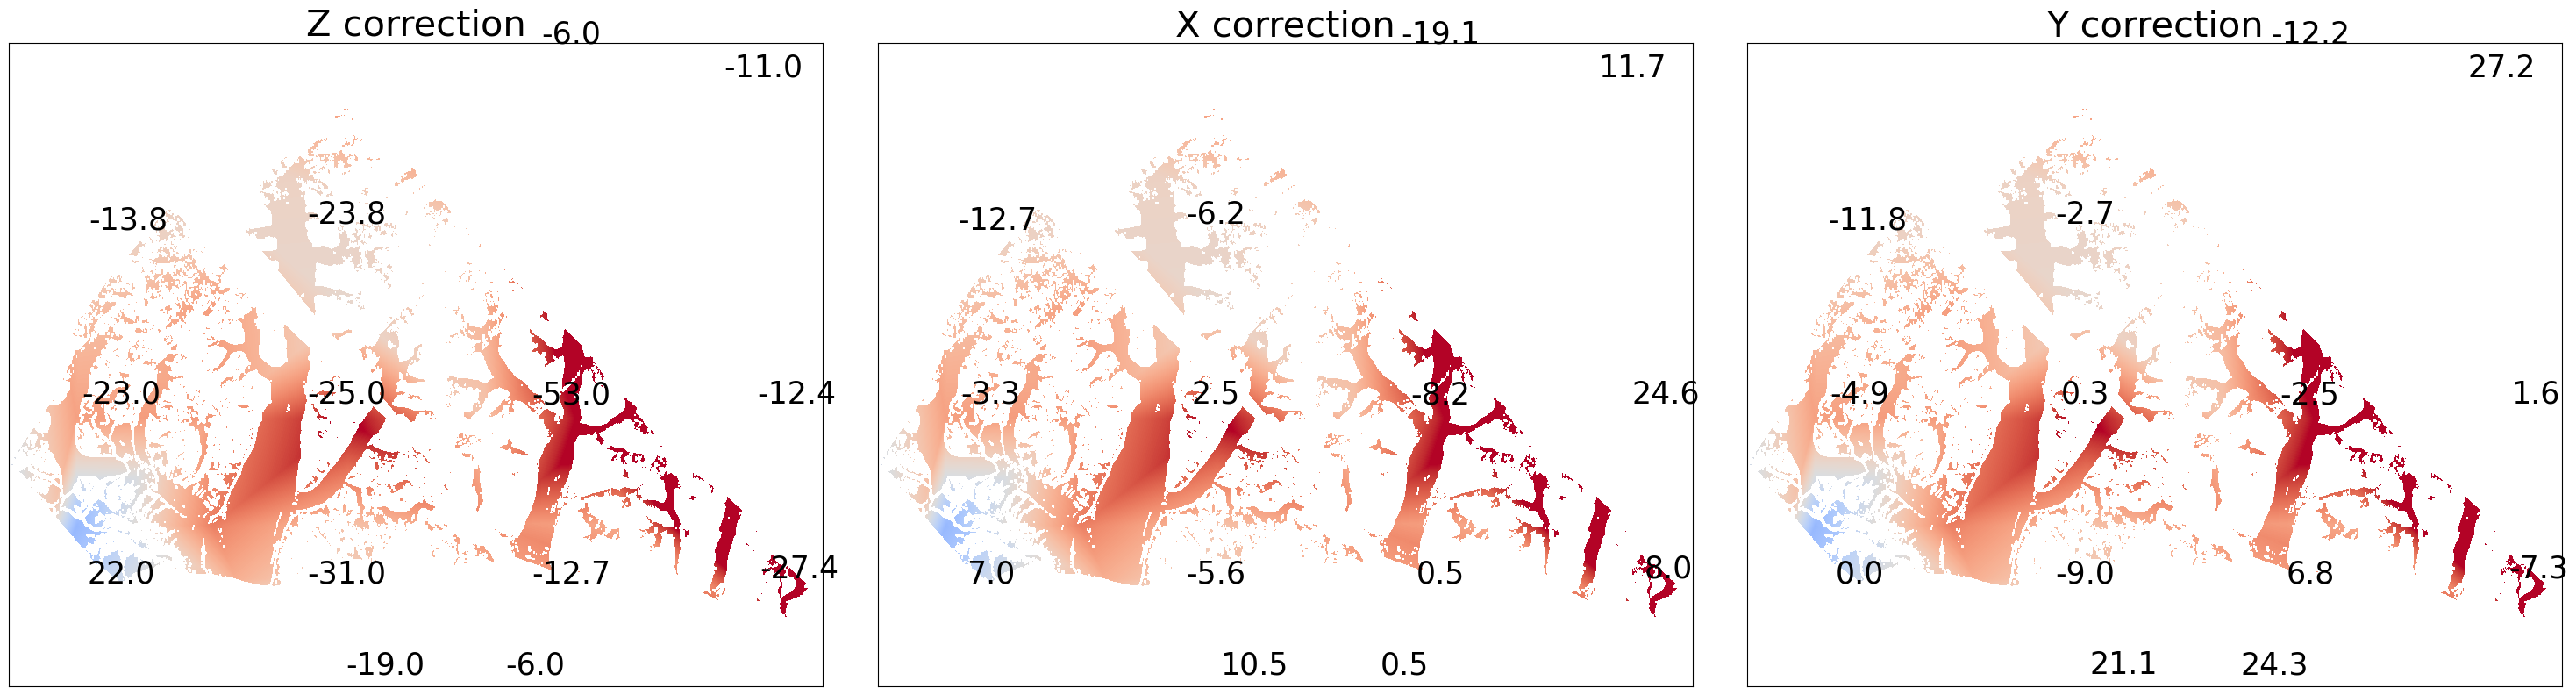

In [ ]:
blockwise = xdem.coreg.BlockwiseCoreg(xdem.coreg.NuthKaab(), subdivision=32)
blockwise.fit(reference_dem, merged_dem, inlier_mask=inlier_mask)
aligned_dem = blockwise.apply(merged_dem)

fig, axs = plt.subplots(1,3, figsize=(30, 10))

# Increase the font size
plt.rcParams.update({'font.size': 25})

# First plot
z_correction = blockwise.apply(
    np.zeros_like(merged_dem.data), transform=merged_dem.transform, crs=merged_dem.crs
)[0]
axs[0].set_title("Z correction")
im1 = axs[0].imshow(z_correction, cmap="coolwarm_r", vmin=-50, vmax=50, extent=plt_extent)
for _, row in blockwise.stats().iterrows():
    axs[0].annotate(round(row["z_off"], 1), (row["center_x"], row["center_y"]), ha="center")
axs[0].set_xlabel('')
axs[0].set_ylabel('')
axs[0].set_xticks([])
axs[0].set_yticks([])

# Second plot
x_correction = blockwise.apply(
    np.zeros_like(merged_dem.data), transform=merged_dem.transform, crs=merged_dem.crs
)[0]
axs[1].set_title("X correction")
im2 = axs[1].imshow(x_correction, cmap="coolwarm_r", vmin=-50, vmax=50, extent=plt_extent)
for _, row in blockwise.stats().iterrows():
    axs[1].annotate(round(row["x_off"], 1), (row["center_x"], row["center_y"]), ha="center")
axs[1].set_xlabel('')
axs[1].set_ylabel('')
axs[1].set_xticks([])
axs[1].set_yticks([])

# Third plot
y_correction = blockwise.apply(
    np.zeros_like(merged_dem.data), transform=merged_dem.transform, crs=merged_dem.crs
)[0]
axs[2].set_title("Y correction")
im3 = axs[2].imshow(y_correction, cmap="coolwarm_r", vmin=-50, vmax=50, extent=plt_extent)
for _, row in blockwise.stats().iterrows():
    axs[2].annotate(round(row["y_off"], 1), (row["center_x"], row["center_y"]), ha="center")
axs[2].set_xlabel('')
axs[2].set_ylabel('')
axs[2].set_xticks([])
axs[2].set_yticks([])

plt.tight_layout()
plt.show()


plt.rcParams.update({'font.size': 10})  # Default matplotlib font size

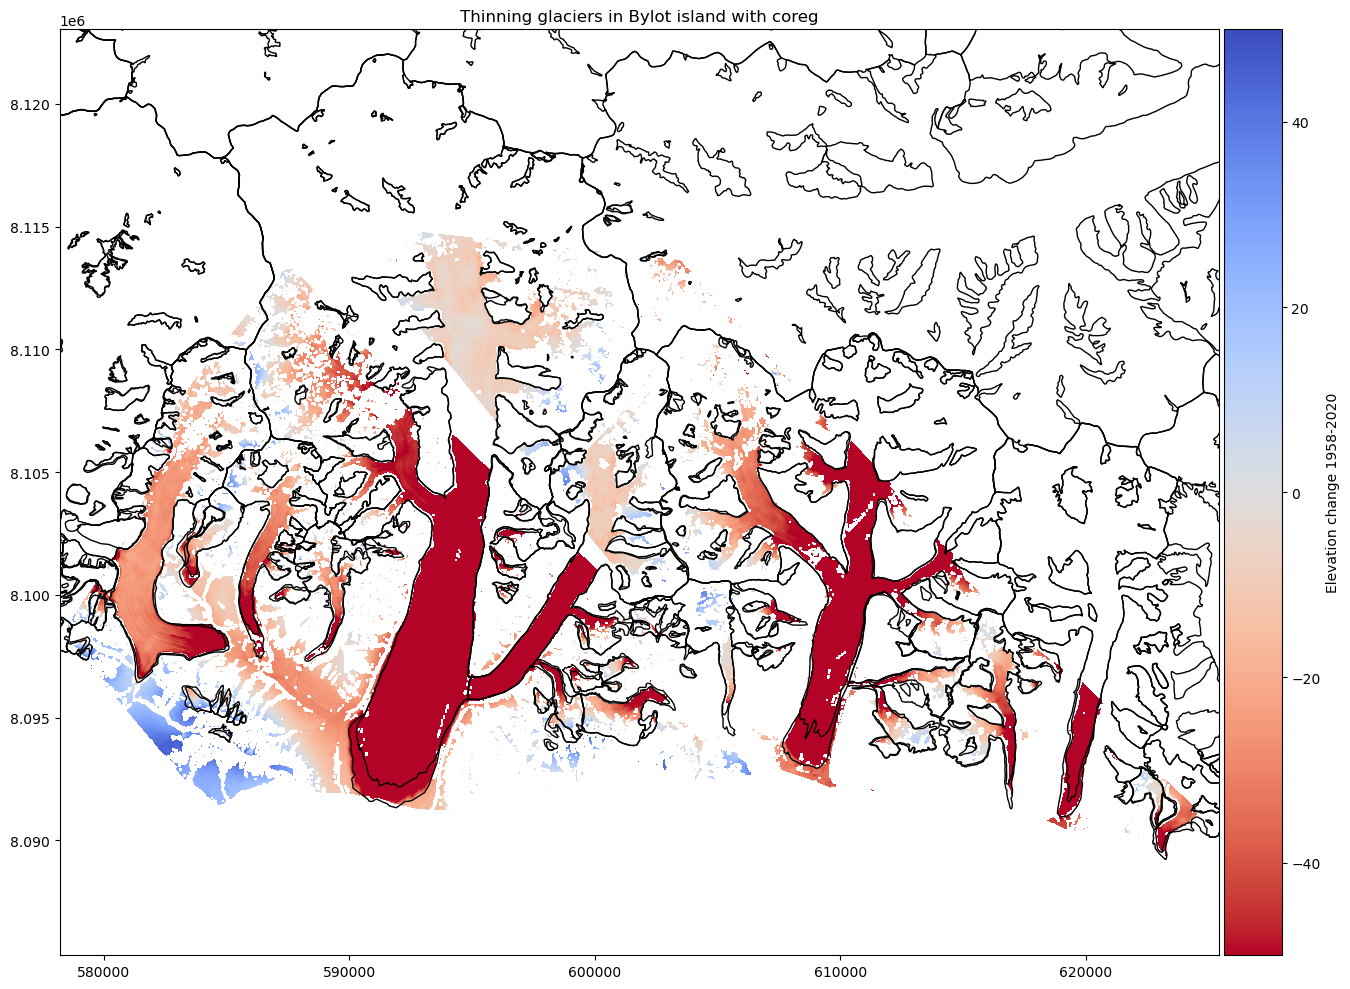

CPLE_AppDefinedError: Deleting D:/SNPDDEMco.tif failed: Permission denied

In [ ]:
ddem_post = reference_dem - merged_dem
#ddem_post.nodata = np.nan

vmax = max(abs(np.max(ddem_post.data)), abs(np.min(ddem_post.data)))

plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
glacier_outlines.ds.plot(ax=ax, facecolor='none', edgecolor='k', zorder=2)
ddem_post.show(ax=ax, cmap='coolwarm_r', vmin=-50, vmax=50, cbar_title='Elevation change 1958-2020', zorder=1)
ax.set_title('Thinning glaciers in Bylot island with coreg')
plt.tight_layout()
plt.show()

ddem_post.save('D://SNPDDEMco.tif')